In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [6]:
def preprocess_image(features):
    """Preprocesses the given image.
       will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
       mean = [103.939, 116.779, 123.68]
       std = None
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    features["image"] = image
    return features

# Load Data

In [7]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

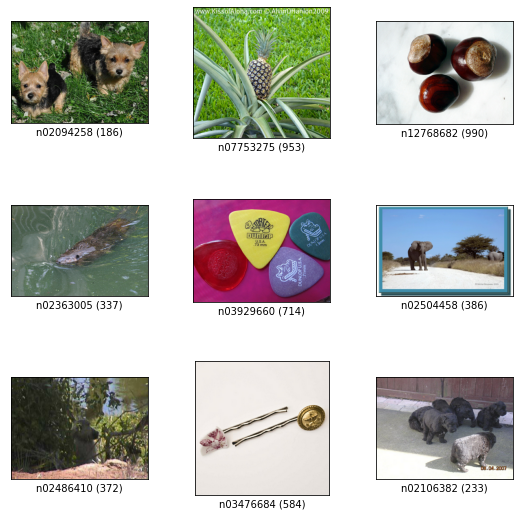

In [8]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [9]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

# Load Model

In [10]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [11]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [12]:
model = ResNet50(input_tensor = q_model.input)

In [13]:
model.load_weights("./fp_model_40_resnet50.h5")
q_model.load_weights("./q_model_40_resnet50.h5")

# Display Image

In [14]:
def extract(ith_image):
    for i, features in enumerate(val_ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features["image"].numpy()[ith_image], axis=0)
            label = features["label"].numpy()[ith_image]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features["image"].numpy()[ith_image%50], axis=0)
            label = features["label"].numpy()[ith_image%50]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
    return image, label,logits_1,logits_2,predict_1,predict_2

In [15]:
image,label,logits_1,logits_2,predict_1,predict_2 = extract(1)

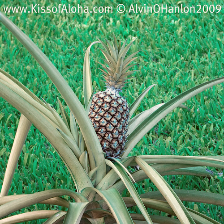

In [16]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)

In [17]:
tf.keras.applications.resnet.decode_predictions(logits_1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9999151),
 ('n07730033', 'cardoon', 2.2061055e-05),
 ('n03991062', 'pot', 7.640851e-06),
 ('n11939491', 'daisy', 5.2376454e-06),
 ('n03457902', 'greenhouse', 4.7309163e-06)]

In [18]:
tf.keras.applications.resnet.decode_predictions(logits_2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.97515965),
 ('n07730033', 'cardoon', 0.002711652),
 ('n03991062', 'pot', 0.0021495393),
 ('n03457902', 'greenhouse', 0.0013507301),
 ('n04311004', 'steel_arch_bridge', 0.0009909474)]

In [35]:
#np.save("./trailer_truck.npy",image)

# Baseline: PGD

$ A = argmax_A \,\, [ \,\, L( \,\, model_{quant} \,\, (image + A) , y )\,\, ]$

In [207]:
grad_iterations = 20
step = 1
epsilon = 8
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0
loss = tf.keras.losses.SparseCategoricalCrossentropy()
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        predict = q_model(input_image + A)
        final_loss = loss(orig_label , predict)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
    print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Oh no!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

[('n02966687', "carpenter's_kit", 0.29293188), ('n03908714', 'pencil_sharpener', 0.17610434), ('n03314780', 'face_powder', 0.11621795), ('n03676483', 'lipstick', 0.051381316), ('n04116512', 'rubber_eraser', 0.032968085)]
[('n02966687', "carpenter's_kit", 0.17999822), ('n02093991', 'Irish_terrier', 0.09687957), ('n02102480', 'Sussex_spaniel', 0.03540371), ('n04090263', 'rifle', 0.032765687), ('n03908714', 'pencil_sharpener', 0.030324232)]
[('n02093991', 'Irish_terrier', 0.75160295), ('n03908714', 'pencil_sharpener', 0.06513585), ('n03314780', 'face_powder', 0.032705292), ('n02094258', 'Norwich_terrier', 0.03146792), ('n02102480', 'Sussex_spaniel', 0.024898702)]
[('n02093991', 'Irish_terrier', 0.7087418), ('n02094258', 'Norwich_terrier', 0.06943894), ('n02102480', 'Sussex_spaniel', 0.040382817), ('n02091635', 'otterhound', 0.02348498), ('n02100877', 'Irish_setter', 0.010826677)]
[('n02093991', 'Irish_terrier', 0.9992341), ('n02094258', 'Norwich_terrier', 0.00024870897), ('n02091635', 'ot

[('n02093991', 'Irish_terrier', 0.9454357), ('n02096051', 'Airedale', 0.047848765), ('n02102318', 'cocker_spaniel', 0.0017099892), ('n02100877', 'Irish_setter', 0.0016892874), ('n02097209', 'standard_schnauzer', 0.0009989624)]
[('n02105251', 'briard', 0.013553463), ('n02093754', 'Border_terrier', 0.013553463), ('n02090721', 'Irish_wolfhound', 0.013553463), ('n02091635', 'otterhound', 0.013553463), ('n02092002', 'Scottish_deerhound', 0.013553463)]
different
[('n02100877', 'Irish_setter', 0.51472694), ('n02102318', 'cocker_spaniel', 0.19846687), ('n02093991', 'Irish_terrier', 0.12811932), ('n02101006', 'Gordon_setter', 0.09112057), ('n02102480', 'Sussex_spaniel', 0.035396725)]
[('n02111129', 'Leonberg', 0.012245321), ('n02093647', 'Bedlington_terrier', 0.012245321), ('n02093991', 'Irish_terrier', 0.012245321), ('n02094433', 'Yorkshire_terrier', 0.012245321), ('n02095314', 'wire-haired_fox_terrier', 0.012245321)]
different


In [208]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n02100877', 'Irish_setter', 0.51472694),
 ('n02102318', 'cocker_spaniel', 0.19846687),
 ('n02093991', 'Irish_terrier', 0.12811932),
 ('n02101006', 'Gordon_setter', 0.09112057),
 ('n02102480', 'Sussex_spaniel', 0.035396725)]

In [209]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02111129', 'Leonberg', 0.012245321),
 ('n02093647', 'Bedlington_terrier', 0.012245321),
 ('n02093991', 'Irish_terrier', 0.012245321),
 ('n02094433', 'Yorkshire_terrier', 0.012245321),
 ('n02095314', 'wire-haired_fox_terrier', 0.012245321)]

# Generate adverserial example

## 1. A = argmax c*L( q_model(image + A) , sudo_y) -  L( orig_model(image + A) , y) 

In [210]:
#image = np.load("./trailer_truck.npy")

In [211]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [212]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [213]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.MSE(model(input_image + A)[0] , q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
Success!


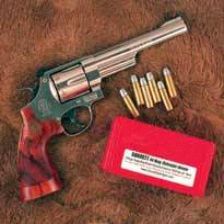

In [214]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [215]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n04086273', 'revolver', 0.92160267),
 ('n04090263', 'rifle', 0.032429215),
 ('n02749479', 'assault_rifle', 0.008850528),
 ('n03527444', 'holster', 0.006879939),
 ('n02966687', "carpenter's_kit", 0.0051436215)]

In [216]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02093991', 'Irish_terrier', 0.05351652),
 ('n03884397', 'panpipe', 0.042422805),
 ('n02102480', 'Sussex_spaniel', 0.03926177),
 ('n04086273', 'revolver', 0.031122994),
 ('n04090263', 'rifle', 0.028803937)]

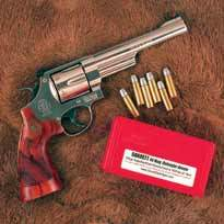

In [217]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

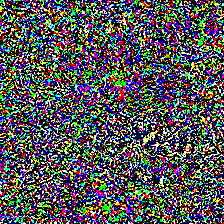

In [218]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

# Transferability

In [19]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
#model__ = ResNet50(input_shape=input_shape)
#t_q_model = tfmot.quantization.keras.quantize_model(model__)
t_model = ResNet50(input_tensor = q_model.input)
t_model.load_weights("./distilled_fp_model_40_resnet50.h5")
#t_q_model.load_weights("./distilled_q_model_40_resnet50.h5")

In [33]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
fp_logist = tf.identity(t_model(image))
fp_label =  np.argmax(fp_logist[0])
A = 0

In [34]:
pred1, pred2, pred3= model(input_image),t_model(input_image), q_model(input_image)

In [35]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9999151),
 ('n07730033', 'cardoon', 2.2061055e-05),
 ('n03991062', 'pot', 7.640851e-06),
 ('n11939491', 'daisy', 5.2376454e-06),
 ('n03457902', 'greenhouse', 4.7309163e-06)]

In [36]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.99811816),
 ('n07730033', 'cardoon', 0.0008981585),
 ('n11939491', 'daisy', 0.00019703251),
 ('n04311004', 'steel_arch_bridge', 0.00013228429),
 ('n13133613', 'ear', 9.113328e-05)]

In [37]:
tf.keras.applications.resnet.decode_predictions(pred3.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.97515965),
 ('n07730033', 'cardoon', 0.002711652),
 ('n03991062', 'pot', 0.0021495393),
 ('n03457902', 'greenhouse', 0.0013507301),
 ('n04311004', 'steel_arch_bridge', 0.0009909474)]

In [38]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [40]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.categorical_crossentropy(t_model(input_image + A)[0] , q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.categorical_crossentropy(fp_logist[0] , t_model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= t_model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    pred3 = model(test_image)
    label3 = np.argmax(pred3[0])
    if not label1 == label2:
        print("different")
        if label1 == fp_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success?")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            if label3 != orig_label:
                print("Oh no!")
            else:
                 print("Success!")
            break

different
Success?
Success!


In [47]:
pred1, pred2= model(test_image), q_model(test_image)

In [48]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.7102253),
 ('n03891251', 'park_bench', 0.0567722),
 ('n03141823', 'crutch', 0.035312098),
 ('n04501370', 'turnstile', 0.021134114),
 ('n02788148', 'bannister', 0.01798954)]

In [49]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n03891251', 'park_bench', 0.06487604),
 ('n03899768', 'patio', 0.04759555),
 ('n02096177', 'cairn', 0.04759555),
 ('n03141823', 'crutch', 0.037729222),
 ('n04099969', 'rocking_chair', 0.034917917)]

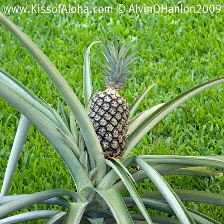

In [50]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

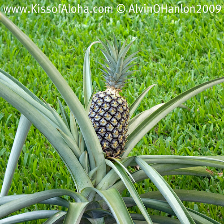

In [51]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

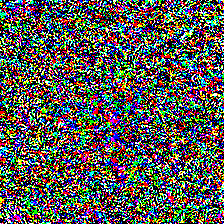

In [62]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [85]:
image = np.load("./trailer_truck.npy")

In [192]:
c = 1
grad_iterations = 20
step = 1
epsilon = 8

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [193]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(input_image+A)[..., orig_label])
        loss2 = K.mean(q_model(input_image+A)[..., orig_label])
        final_loss = K.mean(loss1 - c*loss2)

        grads = normalize(g.gradient(final_loss, input_image))

        # input_image += grads * step    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
different
Success!


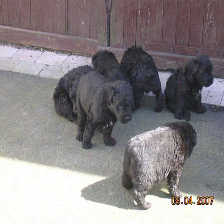

In [194]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [195]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n02106382', 'Bouvier_des_Flandres', 0.9973712),
 ('n02090721', 'Irish_wolfhound', 0.0021722442),
 ('n02105251', 'briard', 0.00025451428),
 ('n02097130', 'giant_schnauzer', 0.00018232176),
 ('n02096177', 'cairn', 9.62178e-06)]

In [196]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02097130', 'giant_schnauzer', 0.16138524),
 ('n02106382', 'Bouvier_des_Flandres', 0.16138524),
 ('n02090721', 'Irish_wolfhound', 0.16138524),
 ('n02105251', 'briard', 0.16138524),
 ('n02097209', 'standard_schnauzer', 0.16138524)]

In [197]:
print(A)

tf.Tensor(
[[[[ 0.  0.  0.]
   [-2.  0.  0.]
   [ 4.  0.  0.]
   ...
   [ 4.  2.  2.]
   [ 2.  4.  4.]
   [-4. -4. -4.]]

  [[ 0.  2.  0.]
   [ 0.  0.  2.]
   [ 2.  0.  2.]
   ...
   [ 4.  4.  2.]
   [ 0.  2.  4.]
   [-2.  2. -2.]]

  [[ 0.  0.  2.]
   [ 4.  2.  2.]
   [ 2.  2. -2.]
   ...
   [ 0.  2. -2.]
   [ 2.  4.  2.]
   [ 2.  2.  2.]]

  ...

  [[ 0. -2. -2.]
   [-2. -2.  4.]
   [ 0.  0.  0.]
   ...
   [ 0.  0.  0.]
   [ 2. -2. -4.]
   [ 0. -2. -2.]]

  [[ 0.  0.  0.]
   [-2. -2. -2.]
   [-2. -2. -2.]
   ...
   [-4. -4. -4.]
   [-4. -2. -2.]
   [-2.  0.  0.]]

  [[-2.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   ...
   [ 0.  0.  2.]
   [-2.  0.  2.]
   [-4. -4. -4.]]]], shape=(1, 224, 224, 3), dtype=float32)


# 3. Cross Entropy Loss

In [93]:
image = np.load("./trailer_truck.npy")

In [36]:
c = 1
grad_iterations = 100
transformation = 'light'
step = 1

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_label =  np.argmax(orig_logist[0])
A = 0
epsilon = 8

In [37]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.categorical_crossentropy(model(input_image+A)[0] , q_model(input_image+A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.categorical_crossentropy(orig_logist[0] , model(input_image+A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        print(final_loss)

    grads = normalize(g.gradient(final_loss, input_image))
    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label_ = np.argmax(pred1[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        print(label1)
        print(label2)
        print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
        print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
        if label_ == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

tf.Tensor(0.024632435, shape=(), dtype=float32)
tf.Tensor(1.9073097, shape=(), dtype=float32)
different
703
192
[('n03891251', 'park_bench', 0.58444065), ('n04099969', 'rocking_chair', 0.07364099), ('n03065424', 'coil', 0.039980598), ('n02788148', 'bannister', 0.035499506), ('n07753275', 'pineapple', 0.029675419)]
[('n02096177', 'cairn', 0.17993566), ('n03891251', 'park_bench', 0.065755755), ('n02097298', 'Scotch_terrier', 0.052124914), ('n02097209', 'standard_schnauzer', 0.04131967), ('n04099969', 'rocking_chair', 0.03539141)]
tf.Tensor(-0.06357074, shape=(), dtype=float32)
different
953
192
[('n07753275', 'pineapple', 0.9211497), ('n03141823', 'crutch', 0.00630693), ('n03065424', 'coil', 0.0059025045), ('n04501370', 'turnstile', 0.004526963), ('n02096177', 'cairn', 0.0037871855)]
[('n02096177', 'cairn', 0.16559218), ('n02097298', 'Scotch_terrier', 0.051831927), ('n02097209', 'standard_schnauzer', 0.0325702), ('n07753275', 'pineapple', 0.0325702), ('n02113712', 'miniature_poodle', 0.0

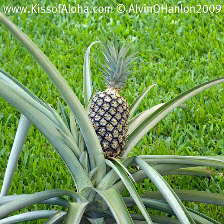

In [38]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [39]:
print(A)

tf.Tensor(
[[[[-1. -1. -1.]
   [-1. -1. -3.]
   [ 3. -1. -3.]
   ...
   [ 1.  1.  1.]
   [ 3. -1. -1.]
   [ 3.  1. -1.]]

  [[-3. -1.  1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [ 1. -1. -3.]
   [-1. -1. -1.]]

  [[-3. -3.  1.]
   [ 1. -3.  1.]
   [ 3. -3.  1.]
   ...
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   [ 1. -1. -1.]]

  ...

  [[-1. -1.  1.]
   [-1. -1.  1.]
   [ 1. -3.  1.]
   ...
   [-3.  3.  3.]
   [-1.  1.  1.]
   [ 1.  1.  1.]]

  [[ 3.  1.  1.]
   [-1. -1. -1.]
   [-1. -1. -3.]
   ...
   [-1.  1.  3.]
   [-1.  1.  1.]
   [-3. -3.  1.]]

  [[-1. -1. -1.]
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [-3. -3.  1.]
   [-1. -3. -1.]]]], shape=(1, 224, 224, 3), dtype=float32)


In [98]:
test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(gen_img_deprocessed), axis=0)
pred1, pred2= model(test_image), q_model(test_image)
label_ = np.argmax(pred1[0])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

In [99]:
label1, label2

(867, 170)